This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



### Preparation

In [2]:
# Standard libraries
import numpy as np
import json
import sys, os
from typing import List


# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService





IBM_TOKEN =""
CRN = ""



LOCAL_QG_PATH = r""
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

print("Using quantum_gates from:", LOCAL_QG_PATH)

import quantum_gates
print("Loaded quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode


def service(ibm_token: str):
    """
    Connect to IBM Quantum service and list available backends.
    
    Parameters
    ----------
    ibm_token : str
        Your IBM Quantum API token.
    """
    backends =[]
    try:
        svc = QiskitRuntimeService(channel="ibm_quantum_platform", token=ibm_token)

        print("✅ Connected to IBM Quantum")
        print("Available backends:")
        for backend in svc.backends():
            print(f" - {backend.name}")
            backends.append(backend.name)
        return backends

    except Exception as e:
        print("❌ Failed to connect to IBM Quantum service.")
        print(f"Reason: {e}")
        return None
    

available_backends = service(IBM_TOKEN)
backend_name = available_backends[1]  # Select the first available backend
    


Using quantum_gates from: /Users/cherie/Desktop/quantum-gates/src
Loaded quantum_gates from: /Users/cherie/Desktop/quantum-gates/src/quantum_gates/__init__.py


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-02 13:22:16,843: Default instance not set. Searching all available instances.


✅ Connected to IBM Quantum
Available backends:
 - ibm_fez
 - ibm_brisbane
 - ibm_torino
 - ibm_marrakesh


### Create Circuit

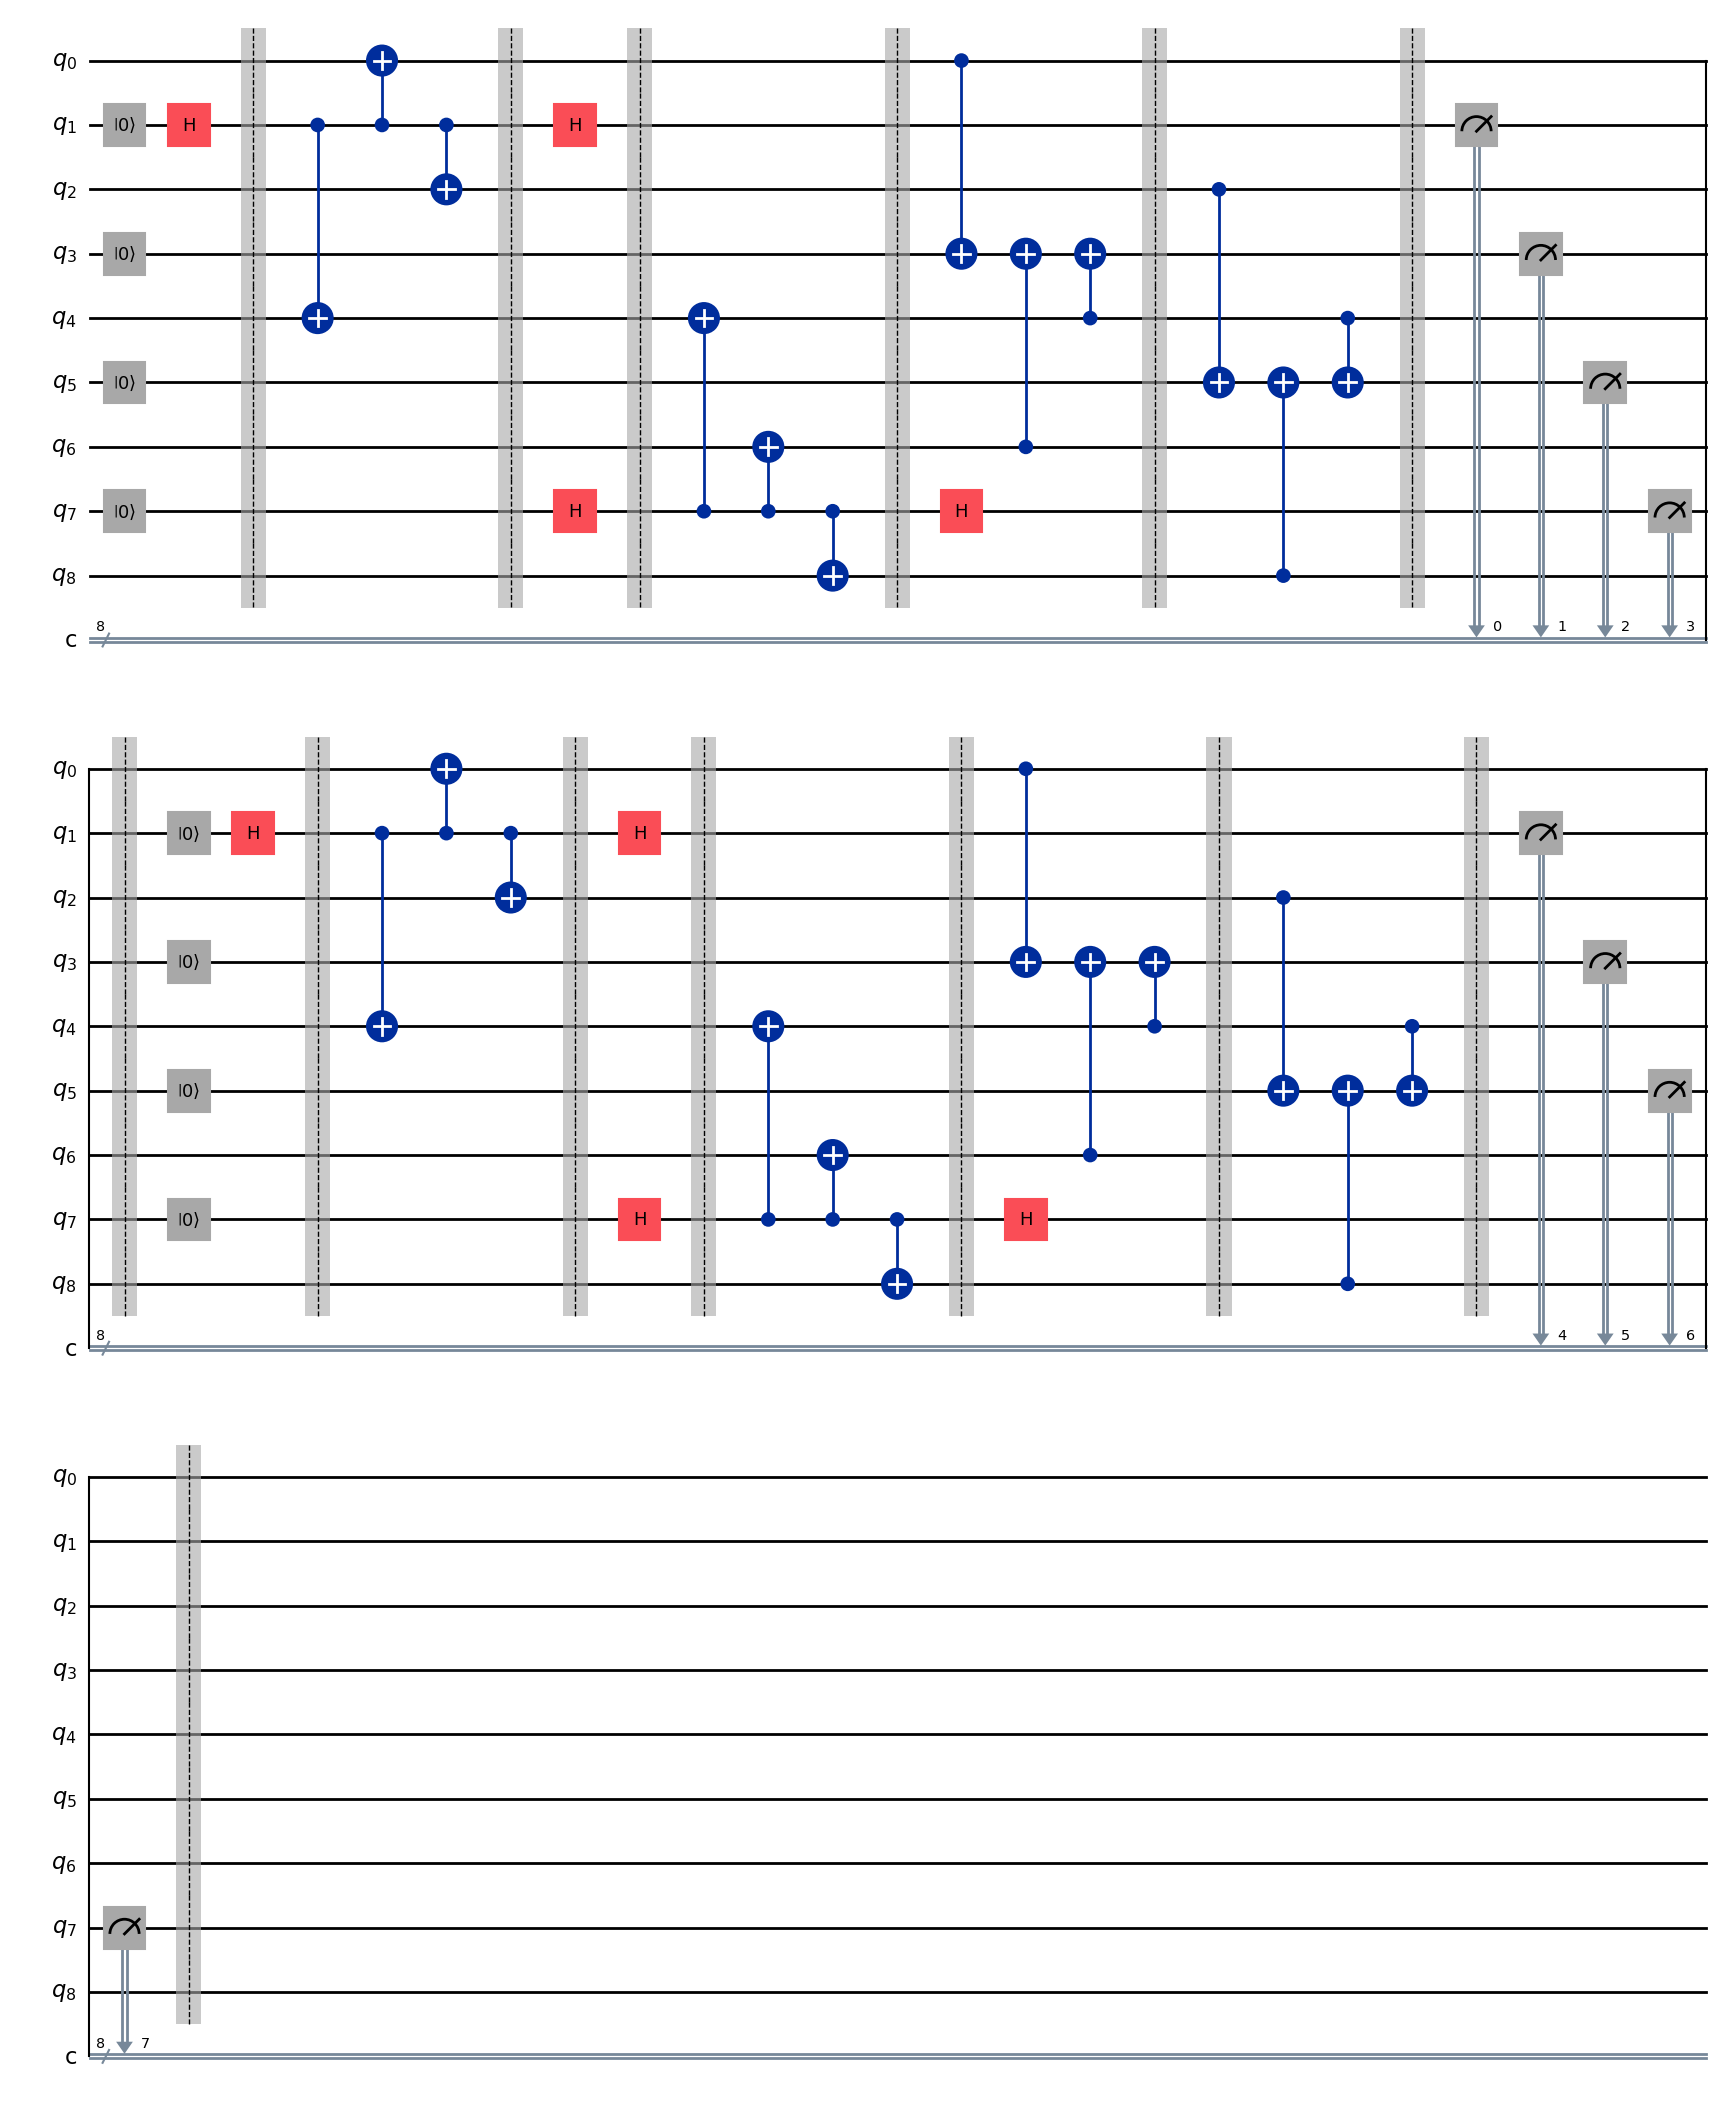

In [3]:
code = SurfaceCode(distance=2, cycles=2)
qc = code.qc
qc.draw("mpl")


In [4]:
n_qubits =code.n_data + code.n_stabilizers
print(code.n_data + code.n_stabilizers)



9


### Run

In [5]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)


initial_psi = np.zeros(2**n_qubits)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(n_qubits))  # logical qubit 0→physical 0, 1→1, etc.
shots = 1

config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": backend_name,
        "crn": CRN
    },
    "run": {
        "shots": shots,
        "qubits_layout": initial_layout,
        "psi0": initial_psi
    }
}

backend_config = config["backend"]
backend = setup_backend(Token=IBM_TOKEN, **backend_config)
run_config = config["run"]

qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()



needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    optimization_level=0,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

# Add this right after transpilation, before sim.run()
print("\n=== CIRCUIT COMPARISON ===")
print(f"Original circuit depth: {qc.depth()}")
print(f"Transpiled circuit depth: {t_circ.depth()}")

# Compare reset operations
print("\n--- Original Circuit Resets ---")
for i, instr in enumerate(qc.data):
    if instr.operation.name == "reset":
        q_idx = qc.find_bit(instr.qubits[0]).index
        print(f"  Instruction #{i}: Reset on qubit {q_idx}")

print("\n--- Transpiled Circuit Resets ---")
for i, instr in enumerate(t_circ.data):
    if instr.operation.name == "reset":
        q_idx = t_circ.find_bit(instr.qubits[0]).index
        print(f"  Instruction #{i}: Reset on qubit {q_idx}")


# Extract the final layout (maps logical -> physical qubits)
final_layout = None
if hasattr(t_circ, '_layout') and t_circ._layout is not None:
    layout_obj = t_circ._layout
    
    # Get the final layout as a list: final_layout[logical_qubit] = physical_qubit
    if hasattr(layout_obj, 'final_index_layout'):
        final_layout = layout_obj.final_index_layout()
    elif hasattr(layout_obj, 'get_virtual_bits'):
        # Alternative method for older Qiskit versions
        final_layout = [layout_obj.get_virtual_bits()[qc.qubits[i]] for i in range(len(qc.qubits))]

print("Final qubit mapping (logical -> physical):", final_layout)

# Create inverse mapping: physical -> logical
if final_layout:
    physical_to_logical = {phys: log for log, phys in enumerate(final_layout)}
else:
    # No layout change, identity mapping
    physical_to_logical = {i: i for i in range(n_qubits)}

print("Physical to logical mapping:", physical_to_logical)

res  = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=n_qubits,
    )


counts = res["probs"]
results = res["results"]

print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
print("Final measurement probabilities:", counts)


=== CIRCUIT COMPARISON ===
Original circuit depth: 32
Transpiled circuit depth: 718

--- Original Circuit Resets ---
  Instruction #0: Reset on qubit 1
  Instruction #1: Reset on qubit 7
  Instruction #2: Reset on qubit 3
  Instruction #3: Reset on qubit 5
  Instruction #31: Reset on qubit 1
  Instruction #32: Reset on qubit 7
  Instruction #33: Reset on qubit 3
  Instruction #34: Reset on qubit 5

--- Transpiled Circuit Resets ---
  Instruction #1: Reset on qubit 1
  Instruction #6: Reset on qubit 3
  Instruction #9: Reset on qubit 5
  Instruction #12: Reset on qubit 7
  Instruction #1049: Reset on qubit 0
  Instruction #1056: Reset on qubit 4
  Instruction #1058: Reset on qubit 5
  Instruction #1062: Reset on qubit 8
Final qubit mapping (logical -> physical): [6, 0, 1, 4, 2, 3, 7, 8, 5]
Physical to logical mapping: {6: 0, 0: 1, 1: 2, 4: 3, 2: 4, 3: 5, 7: 6, 8: 7, 5: 8}
No swaps detected in chunk
Reset on qubit:  1

No swaps detected in chunk
Reset on qubit:  3

No swaps detected in 

In [ ]:
# Before creating the circuit, check your parameter arrays
print("\n=== Parameter Check ===")
print(f"run_config keys: {run_config.keys()}")
for key, value in run_config.items():
    if isinstance(value, np.ndarray):
        print(f"{key}: shape={value.shape}, has NaN={np.any(np.isnan(value))}, has Inf={np.any(np.isinf(value))}")
        if np.any(np.isnan(value)) or np.any(np.isinf(value)):
            print(f"  ⚠️ PROBLEM IN {key}!")
    elif isinstance(value, (list, tuple)):
        print(f"{key}: {value}")

In [ ]:
print(shots)

In [ ]:
code.plot_results(counts, shots, plot_each_shot=True)

